# Machine Learning project : Ensemble optimisation using hyperparameter and architecture search

## Part 1(A) Describing the data set :

The Data set is realted to features(11 features of different wines : fixed_acidity,	volatile_acidity, citric_acid, residual_  sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density, pH, sulphates and alcohol)
Also the data has quality of the wines which will be considered as label in the project.

There are two csv files related to the wine data set : 

1.Train file which will be used to implement training through various methods, also it will be used to test our models through validation sets. Further details will be followed later in the this notebook.

2.Test file is similar to the traning file in terms of features and label with less number of rows which will be used for implementing the final stage of the project which is testing an ensemble method and check the score.



I have created several functions to help with implementing and tunning the hyperparameters used in different methods.

Please see below all the imported libraries at the begining of my coding(python standard, sklearn and my own libraries) which will be helping me to achieve the goal we have been tasked to get to in this project.

In [60]:
import sys                     # import libraries
sys.path.append('.\Library')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
                         
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor\
                            , VotingRegressor, StackingRegressor     # import sklearn libraries 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import accuracy_score

from utils import rgb2gray, get_regression_data, visualise_regression_data# import our libraries
from assigning_library import read_csv_files, split_train_validation, split_features_labels, read_param
from regression_library import low_high_param, show_features_impact, plot_models


## Part 1(B) Load in the training and test splits of the dataset :

Here, initially the two csv files are imported to variables using pandas.

Then, the train csv will be split to header, training and validation sets.

Also, the training and validation sets will be split further to seperate the wine features from the label(wine quality).

Likewise the test csv, will be split to features and label.

In [61]:
path_train_file = "./Data/winequality-red-train.csv"  # assigning the train.csv file path to a variable
path_test_file = "./Data/winequality-red-test.csv"  # assigning the test.csv file path to a variable

my_train_File, my_test_File = read_csv_files(path_train_file, path_test_file)  # reading the csv files using pandas
                                                                       
header, X_train, X_validation, Y_train, Y_validation\
= split_train_validation(my_train_File, split_rate=0.28)  # splitting the train.csv to train and validation arrays

X_test, Y_test = split_features_labels(my_test_File) # splitting the test.csv file to features and label arrays

In [109]:
def prune_models(dataframe, response_col_name):
    
    init_formula_string = response_col_name + " ~ "
    
    cols_no_response = dataframe.columns.tolist()
  
    cols_no_response.remove(response_col_name)
  
    rest_of_formula_string = " + ".join(cols_no_response)
    
    formula_string = init_formula_string + rest_of_formula_string

    model_init = smf.ols(formula_string, data=dataframe).fit()
    
    pvalues = model_init.pvalues
    
    max_p = pvalues.idxmax()
   
    alpha = 0.6
          
    while pvalues.max() > alpha:
        max_p = pvalues.idxmax()
        cols_no_response.remove(max_p)
    
        rest_of_formula_string = " + ".join(cols_no_response)
        formula_string = init_formula_string + rest_of_formula_string
        
        model = smf.ols(formula_string, data=dataframe).fit()
        pvalues = model.pvalues
        pvalues = pvalues.drop("Intercept")
        
    return model
    


In [110]:
wine_df = pd.read_csv("./Data/winequality-red-train.csv")
#print(wine_df.head())
#wine_df.dtypes
wine_df.drop(['Unnamed: 0'], axis=1, inplace = True)
# This is a quick, dirty hack just to allow us to work with some clean data. Don't do stuff like this in practise.
cols = ["fixed_acidity", "volatile_acidity", "citiric_acid", "residul_sugar", "chlorides", "free_sulfur", "total_sulfur", "density", "pH", "sulphates", "alcohol",  "quality"]
wine_df.columns = cols
#print(wine_df.head())
smf.ols("quality ~ alcohol", data=wine_df).fit().summary()
fitted_model = prune_models(wine_df, "quality")

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                quality   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     71.04
Date:                Sat, 19 Sep 2020   Prob (F-statistic):          3.74e-115
Time:                        22:19:24   Log-Likelihood:                -1266.1
No. Observations:                1279   AIC:                             2554.
Df Residuals:                    1268   BIC:                             2611.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           15.4598     19.917      0.776      0.438     -23.614      54.534
fixed_acidity        0.0314      0.027      1.177      0.239      -0.021       0.084
volatile_acidity    -1.0121      0.141     -7.191      0.000      -1.288      -0.736
citiric_acid        -0.2160      0.167     -1.294      0.196      -0.544       0.112
chlorides           -2.0434      0.486     -4.201      0.000      -2.998      -1.089
free_sulfur          0.0093      0.002      3.765      0.000       0.004       0.014
total_sulfur        -0.0038      0.001     -4.750      0.000      -0.005      -0.002
density            -11.0322     20.318     -0.543      0.587     -50.893      28.829
pH                  -0.5746      0.206     -2.796      0.005      -0.978      -0.171
sulphates            0.8482      0.138      6.162      0.000       0.578       1.118
alcohol              0.2963      0.026     11.580      0.000       0.246       0.346
==============================================================================
Omnibus:                        7.086   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.191
Skew:                          -0.095   Prob(JB):                       0.0166
Kurtosis:                       3.343   Cond. No.                     9.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## PART 2 & 3 &(Representation of Part 5) Fit the models on the Data Set and impove the models performance using ensembe methods : 

### Type of models and HyperParameters tuning : 

All models used in this project are in regression form.

RandomForest, AdaBoost and GradienBoost are the regression ensebles which have been used in this project.

Each ensemble of the the ensemble regrssor method has been implemented in 2 different stages :

1. Implementing different HyperParameters for each of the ensembles models(nearly 300 ensemble models for each type of regression at this stage has been trained and tested) from wide range of input. 
Then, sending the best performed HyperParameters to a csv file to be used for further ensemble tuning on second stage.
          
2. Using the csv files where we have the best HyperParameters evaluated from the first stage, similar process will be implemented with a narrower range of input and smaller steps in order to tune further and achieve a better accuracy for the ensemble models.
       

### RandomForest(First Stage):

At first stage 320 different RandomForest ensembles has been trained and tested(using validation sets) using 3 different HyperParameters : n_estimator, max_features and max_depth.

n_estimators used: {100, 200, 300, 400}.

max_features used: {2, 3,..., 9}

Max_depth used : {3, 7, 11,..., 39}

Please see below the best performance found for RandomForest ensembles :

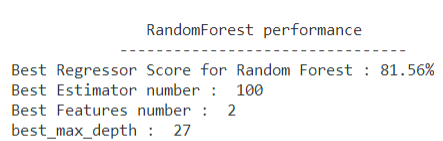

In [10]:
from IPython.display import Image 
Image(filename='./images/RF_res.png')

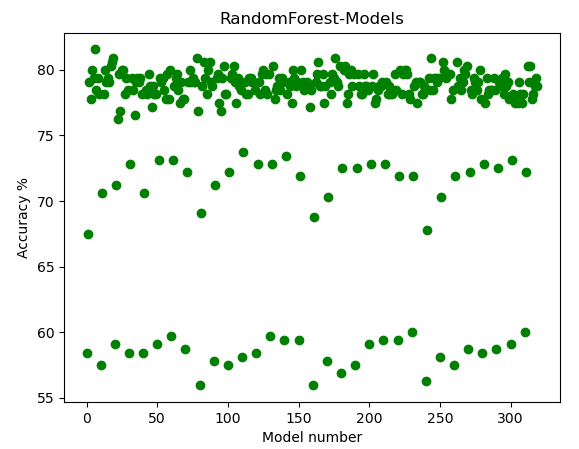

In [11]:
from IPython.display import Image 
Image(filename='./images/RF_PLOT.png')

Best result: model 6 out of 320 models trained with score of 81.56 %

### RandomForest(2nd Stage):

At this stage 27 different RandomForest ensembles has been trained and tested(using validation sets) using 3 different HyperParameters : n_estimator, max_features and max_depth.

The HyperParameters have been read automatically from RandomForest_reg.csv, which has been obtained in the first stage and used for a much narrow range in this stage.

Please note, we can manually change the HyperParameters obtained from 1st stage in the csv file if we prefer it to the automated method.

n_estimators used: {50, 100, 150}.

max_features used: {1, 2, 3}

Max_depth used : {25, 27, 29}

Please see below the best performance found for RandomForest ensembles :

Random Forest Progress :  0 %
Number of estimator of 50 Maximum features of 1 and Maximum depth of 25                     gives accuracy score of 0.00%
Best Score so far :  0 %
Random Forest Progress :  3 %
Number of estimator of 50 Maximum features of 1 and Maximum depth of 27                     gives accuracy score of 77.44%
Best Score so far :  77.44 %
Random Forest Progress :  7 %
Number of estimator of 50 Maximum features of 1 and Maximum depth of 29                     gives accuracy score of 80.22%
Best Score so far :  80.22 %
Random Forest Progress :  11 %
Number of estimator of 50 Maximum features of 2 and Maximum depth of 25                     gives accuracy score of 79.39%
Best Score so far :  80.22 %
Random Forest Progress :  14 %
Number of estimator of 50 Maximum features of 2 and Maximum depth of 27                     gives accuracy score of 78.27%
Best Score so far :  80.22 %
Random Forest Progress : 18 %
Number of estimator of 50 Maximum features of 2 and Maximum dep

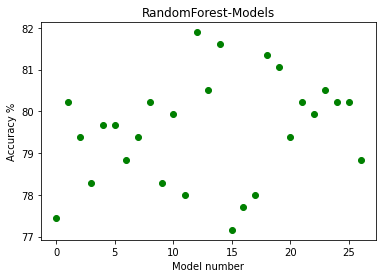

Best model : model  12  with score of  81.89 %


In [5]:
best_regr_score_randomforest = 0  # variable which shows the best scoring RandomForest model
progress_randomforest = 0   # variable which indicates how far have we processed our RandomForest models
regr_score_randomforest = 0 # variable which shows the score for each of the Random Forest model

n_estimator_midpoint, max_features_midpoint, max_depth_midpoint\
                = read_param("./Data/RandomForest_reg.csv", 3) # reading the parameters from 1st stage of RandomForest
n_estimator_step_size = 50 # defining the step change of n_estimator moving from one model to another
n_estimator_strarting_point, n_estimator_ending_point = low_high_param\
(n_estimator_midpoint, n_estimator_step_size, 3) # finding lowest and highest values for n_estimators of RandomForest

max_features_step_size = 1 # defining the step change of max_features moving from one model to another
max_features_starting_point, max_features_ending_point = low_high_param\
(max_features_midpoint,max_features_step_size, 3) # finding lowest and highest values for max_features of RandomForest
    
max_depth_step_size = 2 # defining the step change of max_depth moving from one model to another
max_depth_starting_point, max_depth_ending_point = low_high_param\
(max_depth_midpoint,max_depth_step_size, 3) # finding lowest and highest values for depth_features of RandomForest

randomforest_models = np.zeros((27,2)) # defining an array for accuracy scores
model_idx = 0     # index for each model                           
best_model_score = 0    # variable for the best score

                ### training and testing(through validation sets) all the RandomForest models
for n_estimator_idx in range(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size):             
    for max_features_idx in range(max_features_starting_point, max_features_ending_point, max_features_step_size):      
        for max_depth_idx in range(max_depth_starting_point, max_depth_ending_point, max_depth_step_size):  
            os.system('cls')
            print("Random Forest Progress : ",int(progress_randomforest),"%")  # showing the progress of the process
            print("Number of estimator of {} Maximum features of {} and Maximum depth of {} \
                    gives accuracy score of {:.2f}%".format(n_estimator_idx, max_features_idx, \
                    max_depth_idx, regr_score_randomforest*100))  # score of one single RandomForest model
            print("Best Score so far : ", round(best_regr_score_randomforest*100,2), "%")
            progress_randomforest += 100/27
            randomforestregressor = RandomForestRegressor(n_estimators = n_estimator_idx,  \
                max_features = max_features_idx, max_depth = max_depth_idx) # assigning an instance of a RandomForest
            randomforestregressor.fit(X_train, Y_train)  # fitting the train arrays to each RandomForest model
            Y_prediction = np.around(randomforestregressor.predict(X_validation)) #predicting using the validation set
            regr_score_randomforest = accuracy_score(Y_validation, Y_prediction) #accuaracy score for each model
            randomforest_models[model_idx, 1] = regr_score_randomforest * 100 # saving the score for each model
            randomforest_models[model_idx, 0] = model_idx                 # saving the index for each model
            if regr_score_randomforest > best_regr_score_randomforest: # assessing if the new score is better 
                best_n_estimators_randomforest = n_estimator_idx      # than the previous best score
                best_max_features_randomforest = max_features_idx 
                best_max_depth_randomforest = max_depth_idx  
                best_regr_score_randomforest = regr_score_randomforest
                best_model_score = randomforest_models[model_idx, 1]
                best_model_idx = randomforest_models[model_idx, 0]
            model_idx+=1 
os.system('cls')
print("\n               RandomForest performance ")
print("            --------------------------------") # show the best model of RandomForest tested on validation set
print("Best Regressor Score for Random Forest : {:.2f}%".format(best_regr_score_randomforest*100)) 
print("Best Estimator number : ", best_n_estimators_randomforest, "\nBest Features number : "\
      , best_max_features_randomforest, "\nbest_max_depth : ",best_max_depth_randomforest)

plot_models(randomforest_models[:,0], randomforest_models[:,1], "RandomForest-Models", 'g') # Plot all the models

print("Best model : model ",int(best_model_idx), " with score of ", round(best_model_score,2), "%" )

### AdaBoost(First Stage):

At first stage 279 different AdaBoost ensembles has been trained and tested(using validation sets) using 2 different HyperParameters : n_estimator and learning_rate.

n_estimators used: {10, 20,..., 90}.

learning_rate used: {0.07, 0.10, 0.13,..., 0.97}

Please see below the best performance found for AdaBoost ensembles :

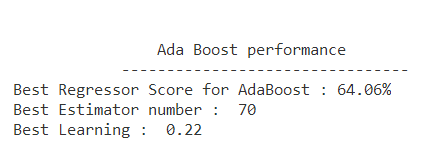

In [6]:
from IPython.display import Image 
Image(filename='./images/AB_res.png')

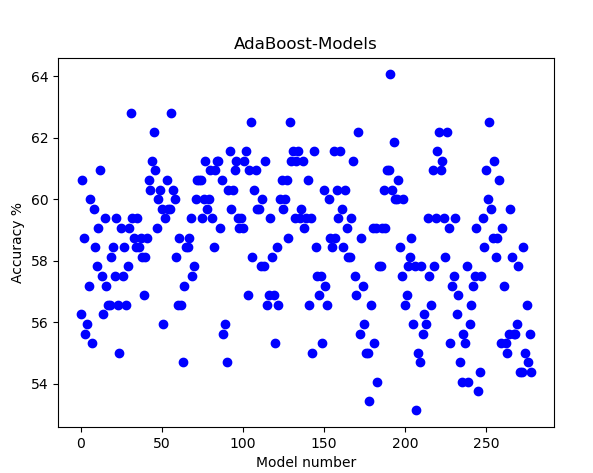

In [7]:
from IPython.display import Image 
Image(filename='./images/AB_PLOT.png')

Best result: model 191 out of 279 models tested with score of 64.06 %

### AdaBoost(2nd Stage):

At this stage 25 different AdaBoost ensembles has been trained and tested(using validation sets) using 2 different HyperParameters : n_estimator and learning_rate.

The HyperParameters have been read automatically from AdaBoost_reg.csv, which has been obtained in the first stage and used for a much narrow range in this stage.

Please note, we can manually change the HyperParameters obtained from 1st stage in the csv file if we prefer it to the automated method.

n_estimators used: {62, 66, 70, 74, 78}.

Learning_rate used: {0.16, 0.19, 0.22, 0.25, 0.28}

Please see below the best performance found for AdaBoost ensembles :

AdaBoost Progress :  0 %
Number of estimator of 22      Learning Rate of 0.25         gives accuracy score of 0.00%
Best Score so far :  0 %
AdaBoost Progress :  4 %
Number of estimator of 22      Learning Rate of 0.28         gives accuracy score of 59.05%
Best Score so far :  59.05 %
AdaBoost Progress :  8 %
Number of estimator of 22      Learning Rate of 0.31         gives accuracy score of 55.71%
Best Score so far :  59.05 %
AdaBoost Progress :  12 %
Number of estimator of 22      Learning Rate of 0.34         gives accuracy score of 61.84%
Best Score so far :  61.84 %
AdaBoost Progress :  16 %
Number of estimator of 22      Learning Rate of 0.37         gives accuracy score of 60.17%
Best Score so far :  61.84 %
AdaBoost Progress :  20 %
Number of estimator of 26      Learning Rate of 0.25         gives accuracy score of 59.05%
Best Score so far :  61.84 %
AdaBoost Progress :  24 %
Number of estimator of 26      Learning Rate of 0.28         gives accuracy score of 57.66%
Best Sco

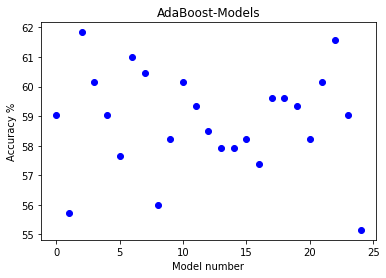

Best model : model  2  with score of  61.84 %


In [8]:
best_regr_score_adaboost = 0 # variable which shows the best scoring AdaBoost model
progress_adaboost = 0  # variable which indicates how far have we processed our AdaBoost models
regr_score_adaboost = 0 # variable which shows the score for each of the AdaBoost model

n_estimator_midpoint, learning_rate_midpoint = read_param("./Data/AdaBoost_reg.csv", 2) # reading the parameters from 1st stage of AdaBoost
n_estimator_step_size = 4 # defining the step change of n_estimator moving from one model to another
n_estimator_strarting_point, n_estimator_ending_point = low_high_param\
(n_estimator_midpoint, n_estimator_step_size, 2) # finding lowest and highest values for n_estimators of AdaBoost

learning_rate_step_size = 3 # defining the step change of max_features moving from one model to another
learning_rate_starting_point, learning_rate_ending_point = low_high_param\
(learning_rate_midpoint, learning_rate_step_size, 2) # finding lowest and highest values for learning_rate of AdaBoost
adaboost_models = np.zeros((25,2)) # defining an array for accuracy scores
model_idx = 0     # index for each model                           
best_model_score = 0    # variable for the best score

                ### training and testing(through validation sets) all the AdaBoost models
for n_estimator_idx in range(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size):             
    for learning_rate_idx in range(learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size):       
        os.system('cls')
        print("AdaBoost Progress : ",int(progress_adaboost),"%")  # showing the progress of the process
        print("Number of estimator of {}      Learning Rate of {} \
        gives accuracy score of {:.2f}%".format(n_estimator_idx, learning_rate_idx/100,\
        regr_score_adaboost*100))  # score of one single AdaBoost model
        print("Best Score so far : ", round(best_regr_score_adaboost*100,2), "%")
        progress_adaboost += 100/25
        adaboostregressor = AdaBoostRegressor(n_estimators = n_estimator_idx,\
        learning_rate = learning_rate_idx/100) # assigning an instance of a AdaBoost
        adaboostregressor.fit(X_train, Y_train)  # fitting the train arrays to each AdaBoost model
        Y_prediction = np.around(adaboostregressor.predict(X_validation)) #predicting using the validation set
        regr_score_adaboost = accuracy_score(Y_validation, Y_prediction) #accuaracy score for each model
        adaboost_models[model_idx, 1] = regr_score_adaboost * 100 # saving the score for each model
        adaboost_models[model_idx, 0] = model_idx    # saving the index for each model
        if regr_score_adaboost > best_regr_score_adaboost: # assessing if the new score is better 
            best_n_estimators_adaboost = n_estimator_idx      # than the previous best score
            best_learning_rate_adaboost = learning_rate_idx  
            best_regr_score_adaboost = regr_score_adaboost
            best_model_score = adaboost_models[model_idx, 1]
            best_model_idx = adaboost_models[model_idx, 0]
        model_idx+=1
os.system('cls')
print("\n                  AdaBoost performance ")
print("            --------------------------------") # show the best model of AdaBoost tested on validation set
print("Best Regressor Score for AdaBoost : {:.2f}%".format(best_regr_score_adaboost*100)) 
print("Best Estimator number : ", best_n_estimators_adaboost, "\nBest Learning rate : "\
      , best_learning_rate_adaboost/100)

plot_models(adaboost_models[:,0], adaboost_models[:,1], "AdaBoost-Models", 'b') # Plot all the models

print("Best model : model ",int(best_model_idx), " with score of ", round(best_model_score,2), "%" )

### GradientBoosting(First Stage):
    
At first stage 280 different GradientBoosting ensembles has been trained and tested(using validation sets) using 3 different HyperParameters : n_estimator, learning_rate and max_depth.

n_estimators used: {60, 70,..., 120}.

learning_rate used: {0.03, 0.08, 0.13, ..., 0.48}

Max_depth used : {3, 5, 7, 9}

Please see below the best performance found for GradientBoosting ensembles :

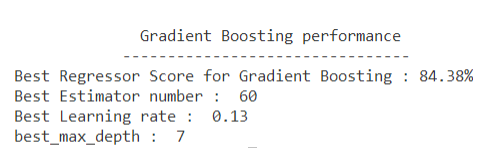

In [9]:
from IPython.display import Image 
Image(filename='./images/GB_res.png')

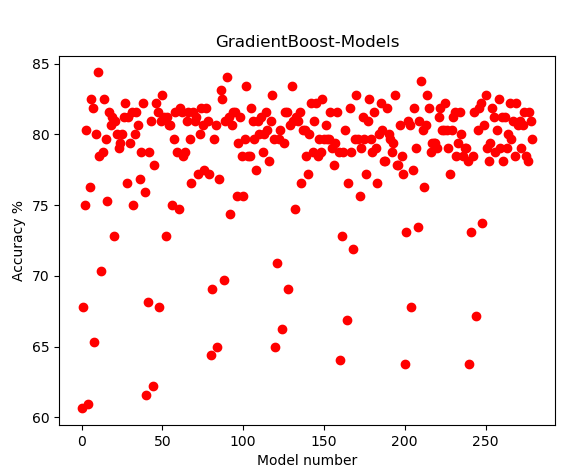

In [10]:
from IPython.display import Image 
Image(filename='./images/GB_PLOT.png')

Best result: model 10 out of 280 models tested, with score of 84.38 %.

### GradientBoosting(2nd Stage):
    
At this stage 27 different GradientBoosting ensembles has been trained and tested(using validation sets) using 3 different HyperParameters : n_estimator, learning_rate and max_depth.

The HyperParameters have been read automatically from GradientBoosting_reg.csv, which has been obtained in the first stage and used for a much narrow range in this stage.

Please note, we can manually change the HyperParameters obtained from 1st stage in the csv file if we prefer it to the automated method.

n_estimators used: {55, 60, 65}.

learning_rate used: {0.11, 0.13, 0.15}

Max_depth used : {6, 7, 8}

Please see below the best performance found for GradientBoosting ensembles :

GradientBoosting Progress :  0 %
Number of estimator of 55     Learning rate of 0.11 and Maximum depth of 6                     gives accuracy score of 0.00%
Best Score so far :  0 %
GradientBoosting Progress :  3 %
Number of estimator of 55     Learning rate of 0.11 and Maximum depth of 7                     gives accuracy score of 80.22%
Best Score so far :  80.22 %
GradientBoosting Progress :  7 %
Number of estimator of 55     Learning rate of 0.11 and Maximum depth of 8                     gives accuracy score of 81.89%
Best Score so far :  81.89 %
GradientBoosting Progress :  11 %
Number of estimator of 55     Learning rate of 0.13 and Maximum depth of 6                     gives accuracy score of 79.94%
Best Score so far :  81.89 %
GradientBoosting Progress :  14 %
Number of estimator of 55     Learning rate of 0.13 and Maximum depth of 7                     gives accuracy score of 83.01%
Best Score so far :  83.01 %
GradientBoosting Progress :  18 %
Number of estimator of 55    

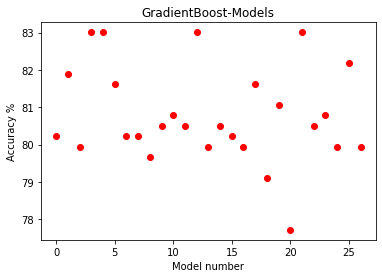

Best model : model  3  with score of  83.01 %


In [11]:
best_regr_score_gradientboosting = 0  # variable which shows the best scoring Gradientboosting model
progress_gradientboosting = 0   # variable which indicates how far have we processed our Gradientboosting models
regr_score_gradientboosting = 0 # variable which shows the score for each of the Gradientboosting model

n_estimator_midpoint, learning_rate_midpoint, max_depth_midpoint\
                = read_param("./Data/Gradientboosting_reg.csv", 3) # reading the parameters from 1st stage of Gradientboosting
n_estimator_step_size = 5 # defining the step change of n_estimator moving from one model to another
n_estimator_strarting_point, n_estimator_ending_point = low_high_param\
(n_estimator_midpoint, n_estimator_step_size, 3) # finding lowest and highest values for n_estimators of Gradientboosting

learning_rate_step_size = 2 # defining the step change of learning_rate moving from one model to another
learning_rate_starting_point, learning_rate_ending_point = low_high_param\
(learning_rate_midpoint,learning_rate_step_size, 3) # finding lowest and highest values for learning_rate of Gradientboosting
    
max_depth_step_size = 1 # defining the step change of max_depth moving from one model to another
max_depth_starting_point, max_depth_ending_point = low_high_param\
(max_depth_midpoint,max_depth_step_size, 3) # finding lowest and highest values for depth_features of Gradientboosting
gradientboost_models = np.zeros((27,2)) # defining an array for accuracy scores
model_idx = 0     # index for each model                           
best_model_score = 0    # variable for the best score    
                ### training and testing(through validation sets) all the Gradientboosting models
for n_estimator_idx in range(n_estimator_strarting_point, n_estimator_ending_point, n_estimator_step_size):             
    for learning_rate_idx in range(learning_rate_starting_point, learning_rate_ending_point, learning_rate_step_size):      
        for max_depth_idx in range(max_depth_starting_point, max_depth_ending_point, max_depth_step_size):  
            os.system('cls')
            print("GradientBoosting Progress : ",int(progress_gradientboosting),"%")  # showing the progress of the process
            print("Number of estimator of {}     Learning rate of {} and Maximum depth of {} \
                    gives accuracy score of {:.2f}%".format(n_estimator_idx, learning_rate_idx/100, \
                    max_depth_idx, regr_score_gradientboosting*100))  # score of one single Gradientboosting model
            print("Best Score so far : ", round(best_regr_score_gradientboosting*100,2), "%")
            progress_gradientboosting += 100/27
            gradientboostingregressor = GradientBoostingRegressor(n_estimators = n_estimator_idx,  \
                learning_rate = learning_rate_idx/100, max_depth = max_depth_idx) # assigning an instance of a Gradientboosting
            gradientboostingregressor.fit(X_train, Y_train)  # fitting the train arrays to each Gradientboosting model
            Y_prediction = np.around(gradientboostingregressor.predict(X_validation)) #predicting using the validation set
            regr_score_gradientboosting = accuracy_score(Y_validation, Y_prediction) #accuaracy score for each model
            gradientboost_models[model_idx, 1] = regr_score_gradientboosting * 100 # saving the score for each model
            gradientboost_models[model_idx, 0] = model_idx       # saving the index for each model
            if regr_score_gradientboosting > best_regr_score_gradientboosting: # assessing if the new score is better 
                best_n_estimators_gradientboosting = n_estimator_idx      # than the previous best score
                best_learning_rate_gradientboosting = learning_rate_idx 
                best_max_depth_gradientboosting = max_depth_idx  
                best_regr_score_gradientboosting = regr_score_gradientboosting
                best_model_score = gradientboost_models[model_idx, 1]
                best_model_idx = gradientboost_models[model_idx, 0]
            model_idx+=1 
os.system('cls')
print("\n             GradientBoosting performance ")
print("            --------------------------------") # show the best model of Gradientboosting tested on validation set
print("Best Regressor Score for Random Forest : {:.2f}%".format(best_regr_score_gradientboosting*100)) 
print("Best Estimator number : ", best_n_estimators_gradientboosting, "\nBest Learning rate : "\
      , best_learning_rate_gradientboosting/100, "\nbest_max_depth : ",best_max_depth_gradientboosting)

plot_models(gradientboost_models[:,0], gradientboost_models[:,1], "GradientBoost-Models", 'r') # Plot all the models

print("Best model : model ",int(best_model_idx), " with score of ", round(best_model_score,2), "%" )


## Part 4: Algorithm to find the best combination of models and hyperparameters

At final stage of ensembling, all three ensembles models : RandomForest, AdaBoost and GradientBoosting has been combined using StackingRegressor.

Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator(A regressor which will be used to combine the base estimators).

In Parts 2&3 the best HyperParameters have been found for each of ensemble model after using 1000s of estimotors.

The best HyperParametersfound in previous parts are being use in the three ensemle models to combine them using the StackingRegressor method.

Please see below the accuracy score for applying and running the code for  the StackingRegressor method on the validation sets:

In [12]:
######### Assigning the best performed HyperParameters in the RandomForest, AdaBoost and GradientBoosting ##########
reg1 = RandomForestRegressor(n_estimators = best_n_estimators_randomforest\
    ,  max_features = best_max_features_randomforest, max_depth = best_max_depth_randomforest)
reg2 = AdaBoostRegressor(n_estimators = best_n_estimators_adaboost,  learning_rate = best_learning_rate_adaboost/100)
reg3 = GradientBoostingRegressor(n_estimators = best_n_estimators_gradientboosting\
    ,  learning_rate = best_learning_rate_gradientboosting/100, max_depth = best_max_depth_gradientboosting)

os.system('cls')
print("\n               StackingRegressor performance on validation sets ")
print("            ----------------------------------------------------------")
stackingregressor = StackingRegressor(estimators=[('rf1', reg1), ('ad1', reg2), ('gb1', reg3)])
stackingregressor = stackingregressor.fit(X_train, Y_train)        ### Fitting the StackingRegressor model #####  
Y_pred = np.around(stackingregressor.predict(X_validation)) ##### Predicting the Labels based on the validation features #####
ensemble_score = accuracy_score(Y_validation, Y_pred)  ##### Calulating the accuracy of each model ####

print("Regressor Score for StackingRegressor : {:.2f}%".format(ensemble_score*100))  ## showing the ensemble score ##
    


               StackingRegressor performance on validation sets 
            ----------------------------------------------------------
Regressor Score for StackingRegressor : 82.17%


Please see below applying the StackingRegressor method on the test sets :

In [13]:
print("\n              StackingRegressor performance on test sets ")
print("            ---------------------------------------------------")

Y_pred = np.around(stackingregressor.predict(X_test)) ##### Predicting the Labels based on the test features #####
ensemble_score = accuracy_score(Y_test, Y_pred)  ##### Calulating the accuracy of each model ####

print("Regressor Score for StackingRegressor : {:.2f}%".format(ensemble_score*100))  ## showing the ensemble score ##


              StackingRegressor performance on test sets 
            ---------------------------------------------------
Regressor Score for StackingRegressor : 67.61%


## Part 5 Presenting the results: 

Please see the graphs in all 3 ensemble models(1st and 2nd stage) in Parts 2 and 3 of this notebook.

AdaBoost is extremely sensitive to Noisy data and outliers. So, this could have an impact in getting a lower accuracy result in comparison to GradientBoost and RandomForest.

The StackingRegressor has accuracy score in range of (80%-85%) on the validation sets, however the accuracy score on the test sets is in range of (65%-70%). 

## Part 6  Most effective features(Ranked) :

LinearRegression model has been applied to training set to obtain the most affective features.

The result is ranked by most effective(which can have negative and positive impact in the quality of the wine we are testing) features impacting the red wine quality.

Alchohol and Sulphates respectively have the highest positve impact on the quality of the Red wine.

The Total sulfur dioxide, volatile acidity and cholrides have negative impact on the quality of the Red wine.

Other six features do not seem to have a great impact on the quality of the Red wine.

Please run the code below to see the result :



In [14]:
os.system('cls')
linearregression = LinearRegression()
linearregression.fit(X_train, Y_train) ### Fitting the LinearRegression model #####

Y_pred = np.around(linearregression.predict(X_validation))  ##### Predicting the Labels based on the validation features #####
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
######## Showing the list of features ranked based the the impact to the prediction ############
show_features_impact(linearregression.coef_, X_train, header)



            Rank Highest impacting features 
          --------------------------------------
Alcohol               with weight of   1.7  and  positive imapct
Sulphates             with weight of   1.2  and  positive imapct
Total sulfur dioxide  with weight of   1.2  and  negative imapct
Volatile acidity      with weight of   1.1  and  negative imapct
Chlorides             with weight of   0.9  and  negative imapct
Fixed acidity         with weight of   0.7  and  positive imapct
Free sulfur dioxide   with weight of   0.6  and  positive imapct
Density               with weight of   0.4  and  negative imapct
Citric acid           with weight of   0.3  and  negative imapct
Ph                    with weight of   0.2  and  negative imapct
Residual sugar        with weight of   0.1  and  positive imapct


# SUMMARY FLOWCHART(Part 5)

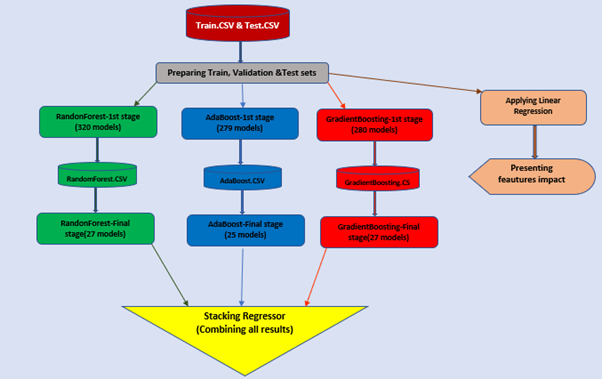

In [15]:
from IPython.display import Image 
Image(filename='./images/Project_Flowchart.png')